In [1]:
import datacube.api
import numpy
import fiona
import geopandas
import rasterio
from affine import Affine
from rasterio.crs import from_string
import osr
from skimage import exposure
from image_processing.segmentation import Segments, rasterise_vector
import matplotlib.pyplot as plt
%matplotlib inline

### Query the datacube

In [2]:
dc = datacube.api.API()

Open the vector file and get the bounding box

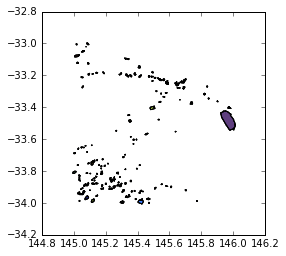

In [3]:
vfname = '/g/data2/v10/public/water-example/sample-water-bodies.shp'
src = fiona.open(vfname, 'r')
xidx = (src.bounds[0], src.bounds[2])
yidx = (src.bounds[-1], src.bounds[1])
gdf = geopandas.read_file(vfname)
gdf.plot()

Using the co-ordinates of the vector file's bunding box, query the datacube.

In [4]:
nbar = dc.get_dataset(product='nbar', platform='LANDSAT_8', 
                      y=yidx, x=xidx)
nbar

<xarray.Dataset>
Dimensions:  (time: 159, x: 4226, y: 4888)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-26T00:09:17.140271 ...
  * y        (y) float64 -3.66e+06 -3.66e+06 -3.66e+06 -3.66e+06 -3.66e+06 ...
  * x        (x) float64 1.192e+06 1.192e+06 1.192e+06 1.192e+06 1.192e+06 ...
Data variables:
    crs      int64 0
    band_6   (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    band_7   (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    band_4   (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    band_5   (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    band_2   (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    band_3   (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    band_1   (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
Attributes:
    source: This data is a reprojection and retile of Landsat surface reflectance scene

Extract and convert the co-ordinate reference system into rasterio's preferred format

In [5]:
sr = osr.SpatialReference()
sr.ImportFromWkt(nbar.crs.spatial_ref)
crs = from_string(sr.ExportToProj4())
print crs

{'lon_0': 132, 'ellps': 'GRS80', 'y_0': 0, 'no_defs': True, 'proj': 'aea', 'x_0': 0, 'units': 'm', 'towgs84': '0,0,0,0,0,0,0', 'lat_2': -36, 'lat_1': -18, 'lat_0': 0}


Create an affine/geotransformtion matrix.

We make an assumption that the spatial array is uniformally spaced in order for this to work.

In [6]:
pix_x = nbar.x.values[1] - nbar.x.values[0]
pix_y = nbar.y.values[1] - nbar.y.values[0]
ulx = nbar.x.values[0] - pix_x / 2.0
uly = nbar.y.values[0] - pix_y  /2.0
transform = Affine.from_gdal(*[ulx, pix_x, 0, uly, 0, pix_y])
print transform

| 25.00, 0.00, 1192000.00|
| 0.00,-25.00,-3659925.00|
| 0.00, 0.00, 1.00|


Determine the pixel size in hectares.  We'll use this later on.

In [7]:
ha = pix_x **2 / 10000.0
print "Pixel area in hectares: {}".format(ha)

Pixel area in hectares: 0.0625


In [8]:
dims = nbar.band_4.shape

In [9]:
img = numpy.zeros((3, dims[1], dims[2]), dtype='float32')
img[0] = nbar.band_5[28]
img[1] = nbar.band_4[28]
img[2] = nbar.band_3[28]
img[img == -999] = numpy.nan
img /= 10000

In [10]:
scl = exposure.equalize_hist(img, mask=numpy.isfinite(img))

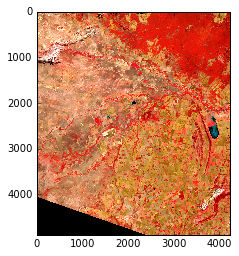

In [11]:
plt.imshow(scl.transpose(1, 2, 0))

### Segmentation

Rasterise all the geometry contained within the vector file, and create a **Segments** object.

In [12]:
ras = rasterise_vector(vfname, shape=dims[1:], crs=crs, transform=transform)
seg = Segments(ras)
print "Number of segments: {}".format(seg.n_segments)

Number of segments: 181


For the **NIR**, **Green**, & **Red** bands, calculate statistics for every segment.

In [13]:
dat = nbar.band_5[28].values.astype('float32')
dat[dat == -999] = numpy.nan
nir_stats = seg.basic_statistics(dat, nan=True, scale_factor=ha)
dat = nbar.band_4[28].values.astype('float32')
dat[dat == -999] = numpy.nan
red_stats = seg.basic_statistics(dat, nan=True, scale_factor=ha)
dat = nbar.band_3[28].values.astype('float32')
dat[dat == -999] = numpy.nan
green_stats = seg.basic_statistics(dat, nan=True, scale_factor=ha)

/g/data/v10/public/modules/agdc-py2-env/anaconda2-2.5.0/envs/agdc/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/g/data/v10/public/modules/agdc-py2-env/anaconda2-2.5.0/envs/agdc/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/g/data/v10/public/modules/agdc-py2-env/anaconda2-2.5.0/envs/agdc/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:227: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)
/g/data/v10/public/modules/agdc-py2-env/anaconda2-2.5.0/envs/agdc/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [14]:
nir_stats.head(10)

,Segment_IDs,Mean,Max,Min,StdDev,Total,Area
0,182,2759.640381,4058.0,1861.0,558.137939,314599.0,37.8750
1,183,1947.141724,2425.0,1504.0,151.191681,467314.0,15.0000
2,184,1646.594849,2214.0,1389.0,226.984085,191005.0,7.2500
3,185,2011.195923,2867.0,1422.0,174.165222,5882748.0,182.8125
4,186,2148.417480,2517.0,1835.0,137.978973,1014053.0,29.5000
5,187,1993.644165,2976.0,900.0,272.751160,7149208.0,224.1250
6,188,NaN,NaN,NaN,NaN,0.0,22.8125
7,189,NaN,NaN,NaN,NaN,0.0,11.6250
8,190,1945.478638,2528.0,1405.0,159.013412,1317089.0,42.3125
9,191,1760.558472,2596.0,1040.0,283.184509,9343284.0,331.6875


### Viewing segments
Get the bounding boxes for every segment

In [15]:
bboxes = seg.bounding_box()

In [16]:
sid = 185
window = bboxes[sid]
ys, ye = window[0]
xs, xe = window[1]
print window

((3582, 3641), (88, 171))


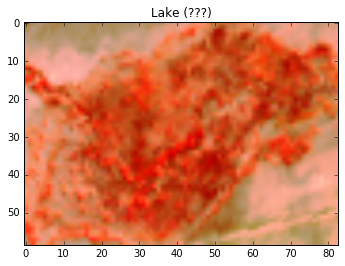

In [17]:
subs = img[:, ys:ye, xs:xe]
scl_subs = exposure.equalize_hist(subs, mask=numpy.isfinite(subs))
plt.title(src[sid - 1]['properties']['FEATURETYP'] +  ' (???)')
plt.imshow(scl_subs.transpose(1, 2, 0))

Find a segment with a low **mean** value.

In [18]:
nir_stats[nir_stats['Mean'] < 500]

,Segment_IDs,Mean,Max,Min,StdDev,Total,Area
175,357,387.886719,3297.0,10.0,583.76947,2653921.0,427.625


In [19]:
sid = 357
window = bboxes[sid]
ys, ye = window[0]
xs, xe = window[1]
print window

((1963, 2049), (2055, 2168))


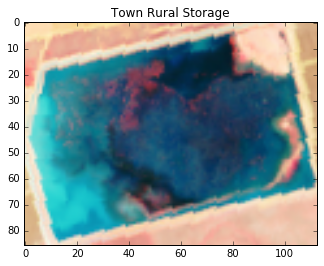

In [20]:
subs = img[:, ys:ye, xs:xe]
scl_subs = exposure.equalize_hist(subs, mask=numpy.isfinite(subs))
plt.title(src[sid - 1]['properties']['FEATURETYP'])
plt.imshow(scl_subs.transpose(1, 2, 0))

In [21]:
sid = 262
window = bboxes[sid]
ys, ye = window[0]
xs, xe = window[1]
print window

((2269, 2821), (3670, 3973))


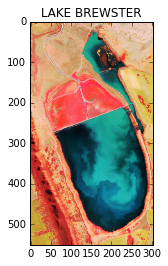

In [22]:
subs = img[:, ys:ye, xs:xe]
scl_subs = exposure.equalize_hist(subs, mask=numpy.isfinite(subs))
plt.title(src[sid - 1]['properties']['NAME'])
plt.imshow(scl_subs.transpose(1, 2, 0))

### Timeseries of the SWIR band for every segment

In [23]:
dat = nbar.band_6[0].values.astype('float32')
dat[dat == -999] = numpy.nan
swir_stats = seg.basic_statistics(dat, nan=True, scale_factor=ha)
swir_stats['timestamp'] = nbar.time[0].values
for i in range(1, dims[0]):
    dat = nbar.band_6[i].values.astype('float32')
    dat[dat == -999] = numpy.nan
    stats = seg.basic_statistics(dat, nan=True, scale_factor=ha)
    stats['timestamp'] = nbar.time[i].values
    swir_stats = swir_stats.append(stats)

In [24]:
swir_stats.set_index('timestamp', inplace=True)

In [25]:
print "Number of records: {}".format(swir_stats.shape[0])
swir_stats.head(10)

Number of records: 28779


,Segment_IDs,Mean,Max,Min,StdDev,Total,Area
timestamp,,,,,,,
2013-03-26 00:09:17.140271,182,NaN,NaN,NaN,NaN,0.0,37.8750
2013-03-26 00:09:17.140271,183,NaN,NaN,NaN,NaN,0.0,15.0000
2013-03-26 00:09:17.140271,184,NaN,NaN,NaN,NaN,0.0,7.2500
2013-03-26 00:09:17.140271,185,NaN,NaN,NaN,NaN,0.0,182.8125
2013-03-26 00:09:17.140271,186,NaN,NaN,NaN,NaN,0.0,29.5000
2013-03-26 00:09:17.140271,187,NaN,NaN,NaN,NaN,0.0,224.1250
2013-03-26 00:09:17.140271,188,NaN,NaN,NaN,NaN,0.0,22.8125
2013-03-26 00:09:17.140271,189,NaN,NaN,NaN,NaN,0.0,11.6250
2013-03-26 00:09:17.140271,190,NaN,NaN,NaN,NaN,0.0,42.3125


### Segment (polygon) timeseries profiles

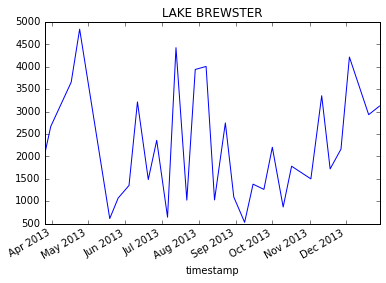

In [26]:
sid = 262
roi = swir_stats[swir_stats['Segment_IDs'] == sid]
roi = roi[numpy.isfinite(roi['Mean'])]
roi['Mean'].plot(title=src[sid - 1]['properties']['NAME'])

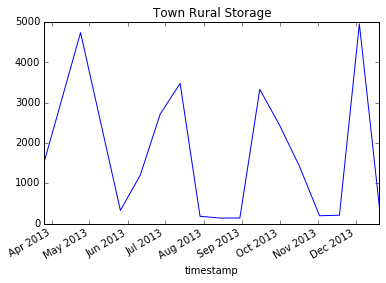

In [27]:
sid = 357
roi = swir_stats[swir_stats['Segment_IDs'] == sid]
roi = roi[numpy.isfinite(roi['Mean'])]
roi['Mean'].plot(title=src[sid - 1]['properties']['FEATURETYP'])

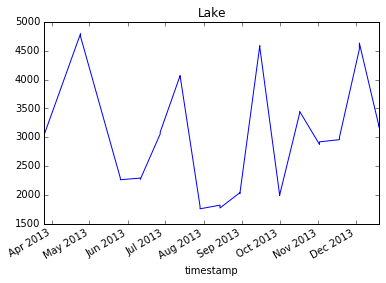

In [28]:
sid = 185
roi = swir_stats[swir_stats['Segment_IDs'] == sid]
roi = roi[numpy.isfinite(roi['Mean'])]
roi['Mean'].plot(title=src[sid - 1]['properties']['FEATURETYP'])

### Investigating a segment/polygon

In [29]:
sid = 262
window = bboxes[sid]
ys, ye = window[0]
xs, xe = window[1]
roi = swir_stats[swir_stats['Segment_IDs'] == sid]
roi = roi[numpy.isfinite(roi['Mean'])]

In [30]:
wh1 = (roi['Mean'] < 1100) & (roi['Total'] > 110000000)
roi[wh1]

,Segment_IDs,Mean,Max,Min,StdDev,Total,Area
timestamp,,,,,,,
2013-05-26 00:10:29.522857,262,1068.986938,3572.0,10.0,1121.092529,111261232.0,6505.0625
2013-08-30 00:10:29.317821,262,1091.199707,4498.0,10.0,1098.150024,113573152.0,6505.0625


In [31]:
wh2 = (roi['Mean'] > 2900) & (roi['StdDev'] < 400)
roi[wh2]

,Segment_IDs,Mean,Max,Min,StdDev,Total,Area
timestamp,,,,,,,
2013-12-20 00:09:54.117418,262,2929.727051,4735.0,152.0,399.086304,304928928.0,6505.0625
2013-12-29 00:03:40.964257,262,3121.633301,4408.0,933.0,348.412964,64780136.0,6505.0625


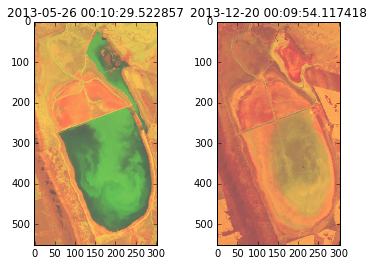

In [32]:
fig, axes = plt.subplots(ncols=2)
timestamp = roi[wh1].index[0]
subs[0] = nbar.band_5.loc[timestamp][ys:ye, xs:xe]
subs[1] = nbar.band_4.loc[timestamp][ys:ye, xs:xe]
subs[1] = nbar.band_3.loc[timestamp][ys:ye, xs:xe]
scl_subs = exposure.equalize_hist(subs, mask=subs != -999)
axes[0].set_title(timestamp)
axes[0].imshow(scl_subs.transpose(1, 2, 0))
timestamp = roi[wh2].index[0]
subs[0] = nbar.band_5.loc[timestamp][ys:ye, xs:xe]
subs[1] = nbar.band_4.loc[timestamp][ys:ye, xs:xe]
subs[1] = nbar.band_3.loc[timestamp][ys:ye, xs:xe]
scl_subs = exposure.equalize_hist(subs, mask=subs != -999)
axes[1].set_title(timestamp)
axes[1].imshow(scl_subs.transpose(1, 2, 0))